In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

def imshow(image):
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[-1] == 1):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Rejestracja obrazu (nakładanie obrazów)

Jest to proces przenoszenia kilku zbiorów danych do jednego układu współrzędnych. Wykorzystywana w obrazowaniu medycznym, widzeniu komputerowym, automatycznym wykrywaniu celu w systemach wojskowych, przetwarzaniu i analizie danych i obrazów z satelitów. Rejestracja jest konieczna, aby porównać lub połączyć dane otrzymane w różny sposób (np. w dwóch różnych modalnościach obrazowania medycznego, np. CT i PET).

Przykładowe dane, które są poddawane rejestracji:

- kilka fotografii (np. wykonane z różnymi parametrami akwizycji), tak aby wydobyć informacje z różnych planów,
- dane z różnych czujników,
- dane otrzymane w różnych chwilach czasowych,
- dane otrzymane z różnych punktów widzenia.

## Główne etapy nakładania obrazów

1. **Wykrywanie i opis cech** - rozpoznawanie punktów kluczowych (zainteresowania - *points of interest*) oraz ich opis na podstawie unikalnych wzorców w otoczeniu tych punktów. W tym celu wykorzystuje się algorytmy określane mianem **deskryptorów cech** (ang. *feature descriptors*). Należą do nich algorytmy SIFT, SURF, ORB lub BRISK.
2. **Dopasowywanie cech** - na podstawie odległości (euklidesowej lub Hamminga) oraz dopasowania - Brute Force (porównywanie wszystkich punktów) lub K-NN.
3. **Odrzucenie outlierów i utworzenie funkcji transformacji** - poprzez tworzenie macierzy transformacji z użyciem np. metody RANSAC - przekształcenie obrazu 2. do perspektywy obrazu 1.

Zacznijmy od wczytania dwóch obrazów, które będziemy łączyć w "panoramę".

(<matplotlib.axes._subplots.AxesSubplot at 0x11c0300b8>,
 None,
 Text(0.5, 1.0, 'train'))

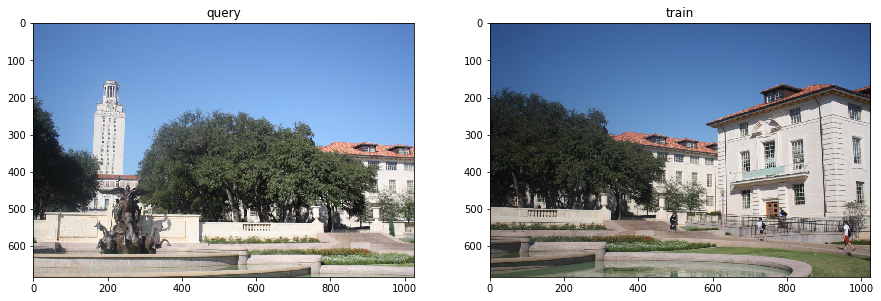

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]
img_train = cv2.imread('agh_cv/panorama1A.jpg')
gray_train = cv2.cvtColor(img_train, cv2.COLOR_BGR2GRAY)

img_query = cv2.imread('agh_cv/panorama1B.jpg')
gray_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2GRAY)

plt.subplot(121), imshow(img_query), plt.title('query')
plt.subplot(122), imshow(img_train), plt.title('train')

## SIFT

SIFT, czyli *Scale Invariant Feature Transform* (skaloniezmiennicze przekształcenie cech) jest można by rzec najbardziej *renomowanym* algorytmem wykrywania i opisu cech. Opiera się on na operatorze *Difference-of-Gaussians*, opierającym się na odejmowaniu obrazu rozmytego maską gaussowską od obrazu pierwotnego, a następnie szukane są lokalne maksima (które mają wskazywać na wykryte cechy). Proces powtarzany jest dla wielokrotnie przeskalowanego obrazu (stąd *Scale Invariant*), na koniec tworząc wektor opisujący cechę na podstawie otoczenia piksela, reprezentującego cechę (segmentacja regionu 16x16).

In [3]:
# utwórz deskryptor SIFT
descriptor = cv2.xfeatures2d.SIFT_create()
# detekcja punktów kluczowych oraz deskryptorów cech
kps_query, features_query = descriptor.detectAndCompute(gray_query, None) # None dla maski - nie potrzebujemy
kps_train, features_train = descriptor.detectAndCompute(gray_train, None)

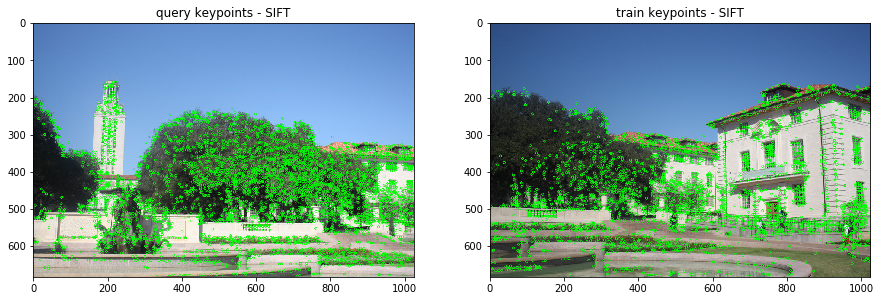

In [4]:
plt.subplot(121)
imshow(cv2.drawKeypoints(img_query, kps_query, None, color=(0, 255, 0))) # outImage ma być None
plt.title('query keypoints - SIFT')
plt.subplot(122)
imshow(cv2.drawKeypoints(img_train, kps_train, None, color=(0, 255, 0)))
plt.title('train keypoints - SIFT')
plt.show()

### Zadanie

1. Przygotuj funkcję `describe(image, descriptor)`, która pobierze obraz oraz metodę (obiekt utworzony przez `cv2.xfeatures2d.SIFT_create()`, a następnie dla obrazu zwróci punkty kluczowe oraz cechy, uzyskane przez wywołanie funkcji `descriptor.detectAndCompute()`.

2. Przygotuj funkcję `draw_keypoints(image, descriptor)`, która, wywołując funkcję `describe` narysuje na obrazie `image` wykryte punkty.

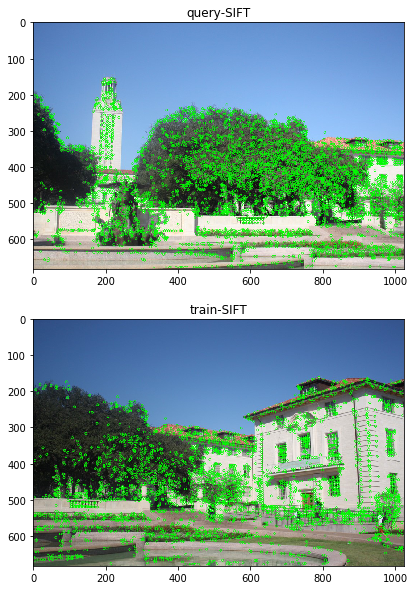

In [5]:
def describe(image, descriptor):
    return descriptor.detectAndCompute(image, None)

def draw_keypoints(image, descriptor):
    kps, _ = describe(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),
                      descriptor)
    return cv2.drawKeypoints(image, kps, None, color=(0, 255, 0))

descriptor = cv2.xfeatures2d.SIFT_create()
plt.subplot(211)
imshow(draw_keypoints(img_query, descriptor))
plt.title('query-SIFT')
plt.subplot(212)
imshow(draw_keypoints(img_train, descriptor))
plt.title('train-SIFT')
plt.show()

## SURF

Skrót SURF oznacza *Speeded Up Robust Features*. Metoda ta również polega na analizie obrazu w oparciu o rozmycie gaussowskie. SURF wykorzystuje wyznacznik Hesjanu (macierz Hessego, *Hessian Matrix*) w postaci:

$$\mathscr{H} = \left[\begin{matrix} {L_{xx} (x, \sigma)}, {L_{xy} (x, \sigma)} \\ {L_{yx} (x, \sigma)}, {L_{yy} (x, \sigma)} \end{matrix} \right] $$

gdzie $L_{xx} (x, \sigma)$ to splot laplasjanu (pochodnej drugiego stopnia z filtra gaussowskiego z obrazem dla punktu x). Do opisu otoczenia wykrytych punktów wykorzystywana jest falka Haara, jak na wykresie:

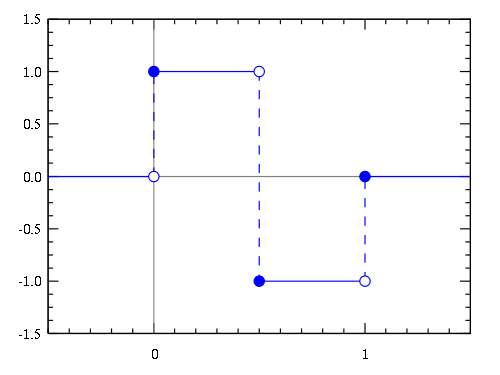

Największą przewagą metody SURF nad SIFTem jest jej większa szybkość działania.

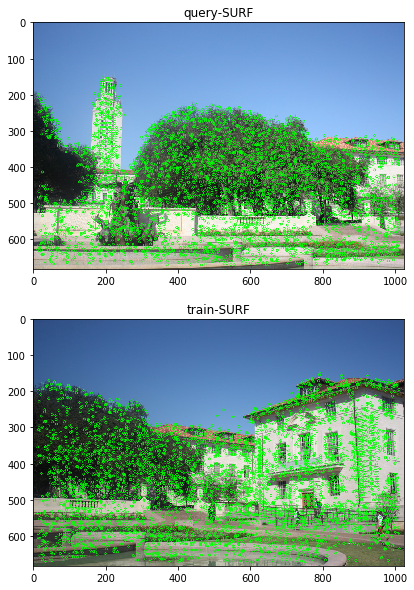

In [6]:
# utwórz deskryptor SURF - ma on tę samą metodę `detectAndDescribe` co SIFT!
descriptor = cv2.xfeatures2d.SURF_create()

plt.subplot(211)
imshow(draw_keypoints(img_query, descriptor))
plt.title('query-SURF')
plt.subplot(212)
imshow(draw_keypoints(img_train, descriptor))
plt.title('train-SURF')
plt.show()

## BRISK

*Binary Robust Invariant Scalable Keypoints* to metoda dokonująca detekcji punktów z użyciem algorytmu AGAST, filtrująca używając miary Harrisa, szukając maksymalnych wartości dla zmiennej skali. Opis cech oparty jest na rozpoznawaniu charakterystycznych kierunków każdej cechy.

Metoda BRISK osiąga najwyższą dokładność (porównywalną z SIFTem).

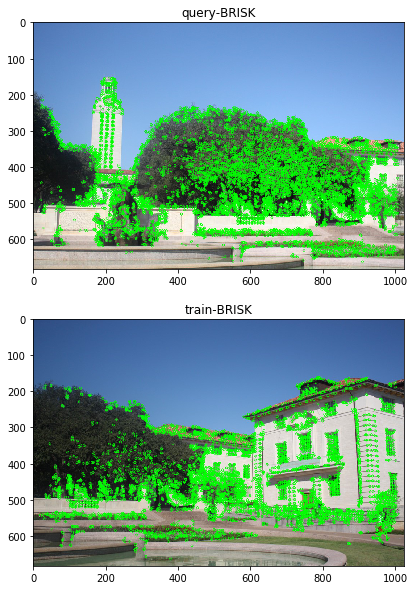

In [7]:
# również BRISK posiada metodę detectAndDescribe
descriptor = cv2.BRISK_create()

plt.subplot(211)
imshow(draw_keypoints(img_query, descriptor))
plt.title('query-BRISK')
plt.subplot(212)
imshow(draw_keypoints(img_train, descriptor))
plt.title('train-BRISK')
plt.show()

## ORB

Algorytm ten (*Oriented FAST and Rotated BRIEF*) stanowi połączenie algorytmu FAST (*Features from Accelerated Segment Test*) do detekcji oraz BRIEF (*Binary Robust Independent Elementary Features*) do opisu cech. Rogi wykrywane są poprzez analizę otoczenia badanego piksela (16 pikseli) - jeżeli N pikseli w otoczeniu jest jaśniejszych lub ciemniejszych niż jasność tego piksela to jest on uznawany za punkt rogu. Proces ten powtarzany jest dla zmiennej skali, a następnie wybierane są najlepsze punkty z użyciem miary Harrisa do oceny rogów (*Harris Corner score*). Następnie, wektor opisujący punkt generowany jest z użyciem metody BRIEF (która jest raczej skomplikowana, choć szybka i skuteczna).

Algorytm ten jest bardziej odporny na rotację, ale mniej na zmienną skalę.

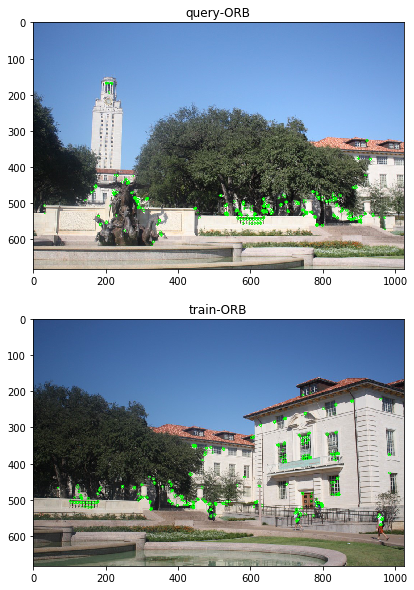

In [8]:
# ORB także ma metodę detectAndDescribe
descriptor = cv2.ORB_create()

plt.subplot(211)
imshow(draw_keypoints(img_query, descriptor))
plt.title('query-ORB')
plt.subplot(212)
imshow(draw_keypoints(img_train, descriptor))
plt.title('train-ORB')
plt.show()

In [9]:
# zdefiniujmy słownik deskryptorów
descriptors = {'sift': cv2.xfeatures2d.SIFT_create(),
               'surf': cv2.xfeatures2d.SURF_create(),
               'brisk': cv2.BRISK_create(),
               'orb': cv2.ORB_create()}

## Dopasowywanie cech

Jak widać, uzyskaliśmy w każdym przypadku wiele cech, z pomocą których możemy opisać każdy obrazek. Teraz chcielibyśmy porównać dwa zbiory cech i połączyć te o dużym podobieństwie - na podstawie pewnej miary odległości.

W OpenCV potrzebujemy w tym celu obiektu `Matcher`. Domyślnie wykorzystuje on miarę euklidesową, która jest zalecana dla metod SIFT oraz SURF. Dla innych metod, jak ORB lub BRISK lepiej zastosować odległość Hamminga.

Zdefiniujmy sobie funkcję, która zwróci odpowiedni obiekt `Matcher` w zależności od stosowanej metody.

Parametr `crossCheck` mówi o tym, czy dwie cechy muszą być do siebie dopasowane by zostać uznanym za poprawne (dla cech *f1* i *f2* - czy *f1* dopasowano do *f2* oraz *f2* dopasowano do *f1* jako najbliższe dopasowanie).

In [10]:
def get_matcher(method, cross_check):
    if method in ['sift', 'surf']:
        return cv2.BFMatcher(cv2.NORM_L2, crossCheck=cross_check)
    elif method in ['orb', 'brisk']:
        return cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=cross_check)

print(get_matcher('surf', False))

<BFMatcher 0x11cc2c2d0>


W OpenCV mamy dwa dostępne podejścia do dopasowywania wykrytych cech.

### Brute Force

Jest to wersja, gdzie dla dwóch zbiorów cech, każda cecha ze zbioru A jest porównywana z każdą cechą ze zbioru B, a następnie zwraca dla każdej cechy A najbliższą cechę ze zbioru B.

In [11]:
bf = get_matcher('sift', True) # dla BF crossCheck ma być True
best_matches = bf.match(describe(gray_query, descriptors['sift'])[1],
                        describe(gray_train, descriptors['sift'])[1])

raw_matches = sorted(best_matches, key = lambda x: x.distance)
print(f'Raw matches BF: {len(raw_matches)}')


Raw matches BF: 2562


### K-NN

Aby rozpatrywać więcej niż jedno dopasowanie-kandydata, wykorzystamy procedurę opartą na K-NN. Podejście to zwraca `k` najlepszych dopasowań (`k` musi być zdefiniowane odgórnie). Jednak, by przejść dalej musimy zapewnić, że zaproponowane pary są poprawne.

Tutaj nie korzystamy już z `crossCheck`, a z testowania współczynnikiem (`ratio test`) - iterujemy po liście par zwróconyh przez K-NN i obliczamy dystans. Dla każdej pary cech, jeżeli dystans jest poniżej określonego współczynnika to para jest zachowywana. Oczywiście, współczynnik ten dobieramy ręcznie.

In [26]:
ratio = 0.75
bf = get_matcher('sift', False)  # K-NN nie korzysta z crossCheck, a z ratio test
raw_matches = bf.knnMatch(describe(gray_query, descriptors['sift'])[1],
                          describe(gray_train, descriptors['sift'])[1], 2)  # k dopasowań
print(f'Raw matches K-NN: {len(raw_matches)}')

# ratio test
matches = []
for m, n in raw_matches:
    # check distance
    if m.distance < n.distance * ratio:
        matches.append(m)
print(f'Matches after ratio test: {len(matches)}')

Raw matches K-NN: 5342
Matches after ratio test: 1098


### Zadanie

Przygotuj funkcje `match_kps_bf(feature_1, feature_2, method)` oraz `match_kps_knn(feature_1, feature_2, ratio, method)`, które wykonają dopasowanie obu cech używając odpowiednio metody BF oraz K-NN (na podstawie komórek przygotowanych wcześniej) oraz zwróci listę dopasowanych cech.

In [13]:
def match_kps_bf(feature_1, feature_2, method):
    bf = get_matcher(method, True)
    best_matches = bf.match(feature_1, feature_2)
    raw_matches = sorted(best_matches, key = lambda x: x.distance)
    return raw_matches

def match_kps_knn(feature_1, feature_2, ratio, method):
    bf = get_matcher(method, False)
    raw_matches = bf.knnMatch(feature_1, feature_2, k=2)
    # ratio test
    matches = []
    for m, n in raw_matches:
        # check distance
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches


## Łączenie punktów

Spróbujmy teraz dokonać połączenia powiązanych punktów dla zadanych obrazów, porównując metode BF oraz K-NN.

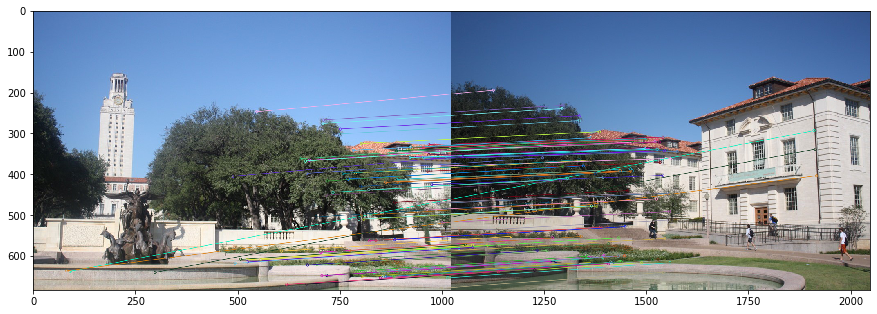

In [27]:
method = 'sift'

kps_query, feature_query = describe(gray_query, descriptors[method])
kps_train, feature_train = describe(gray_train, descriptors[method])

matches = match_kps_bf(feature_query, feature_train,
                       method=method)

imshow(cv2.drawMatches(img_query, kps_query,
                       img_train, kps_train,
                       matches[:100],
                       None, # outImg
                       flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))

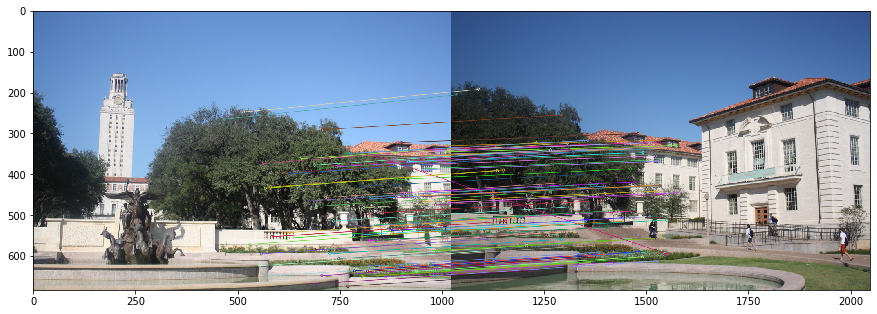

In [28]:
matches = match_kps_knn(feature_query, feature_train, ratio=0.75,
                       method=method)

imshow(cv2.drawMatches(img_query, kps_query,
                       img_train, kps_train,
                       np.random.choice(matches, 100),
                       None, # outImg
                       flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))

## Macierz transformacji

Warto zwrócić uwagę, że niestety nawet teraz, niektóre cechy nie są w pełni dopasowany. Musimy się tym zająć przy tworzeniu macierzy transformacji - macierzy homografii (*Homography matrix*).

Jest to macierz 3x3, która może być używana np. do poprawy perspektywy oraz do łączenia obrazów w panoramę. Jest to przekształcenie 2D, mapujące punkty z jednej płaszczyzny do innej.

Aby zadbać o zignorowanie outlierów wykorzystamy agorytm RANSAC (*RANdom SAmple Consensus*), czyli iteracyjnego algorytmu do dopasowywania modeli liniowych. Jedną z jego podstawowych zalet jest zdolność do ignorowania outlierów.

W odróżnieniu od klasycznej regresji liniowej, algorytm RANSAC estymuje parametry tylko dla podzbioru wartości, tzw. inlierów. Obraz poniżej pokazuje porównanie klasycznej regresji liniowej i algorytmu RANSAC - regresja liniowa jest pod dużym wpływem outlierów, bo dąży do minimalizacji średniego błędu, natomiast RANSAC dopasowuje się tylko do podzbioru punktów, zidentyfikowanych jako *inliers*.

![obraz](https://miro.medium.com/max/1280/0*Tq8ui-bw80I8y3Qm.png)

My wykorzystamy RANSAC do estymacji macierzy homografii

In [29]:
threshold = 4  # próg dla metody RANSAC (max reprojection error by traktować jako inlier)
# konwersja punktów kluczowych do macierzy numpy
kps_query_arr = np.float32([kp.pt for kp in kps_query])
kps_train_arr = np.float32([kp.pt for kp in kps_train])

if len(matches) > 4: # tylko wtedy można utworzyć macierz
    points_train = np.float32([kps_train_arr[m.trainIdx] for m in matches])
    points_query = np.float32([kps_query_arr[m.queryIdx] for m in matches])
    # queryIdx to współrzędne w bazowym obrazie
    # a trainIdx to współrzędne na dołączanym
    
    # tworzymy macierz
    H, _status = cv2.findHomography(points_train, points_query,
                                    cv2.RANSAC, threshold)

print(H)

[[ 7.72823609e-01  2.56530233e-02  4.47728485e+02]
 [-1.30215388e-01  9.03724637e-01  7.68996168e+01]
 [-1.99807776e-04 -4.57249364e-05  1.00000000e+00]]


Zastosujmy teraz tę macierz!

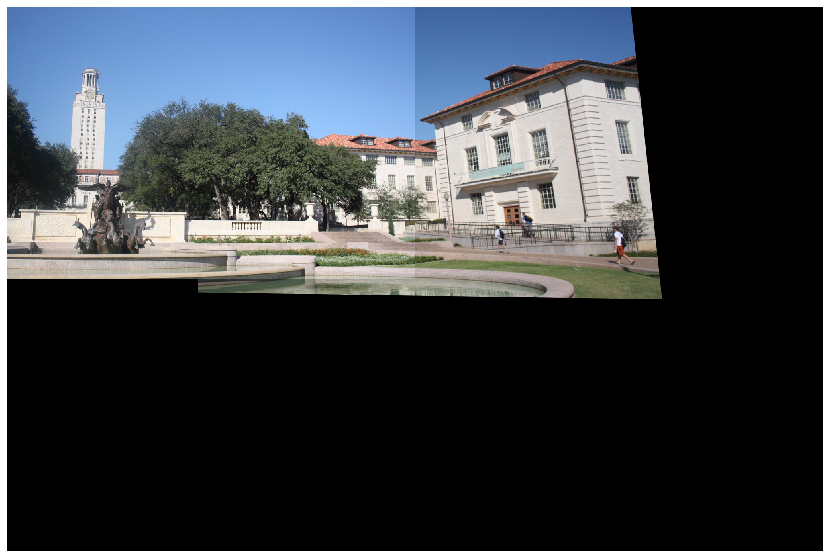

In [30]:
width = img_query.shape[1] + img_train.shape[1]
height = img_query.shape[0] + img_train.shape[0]

# przekształć dołączany obraz
result = cv2.warpPerspective(img_train, H, (width, height))

# dołącz obraz bazowy
result[:img_query.shape[0], :img_query.shape[1]] = img_query

plt.figure(figsize=(20, 10))
imshow(result)
plt.axis('off')
plt.show()


### Zadanie

Przygotuj funkcję `get_homography(kps_query, kps_train, matches, reproj_thresh)`, która dla podanych punktów kluczowych, dopasowań oraz progu zwróci macierz przekształcenia.

In [18]:
def get_homography(kps_query, kps_train, matches, reproj_thresh):
    # konwersja punktów kluczowych do macierzy numpy
    kps_query_arr = np.float32([kp.pt for kp in kps_query])
    kps_train_arr = np.float32([kp.pt for kp in kps_train])

    if len(matches) > 4: # tylko wtedy można utworzyć macierz
        points_train = np.float32([kps_train_arr[m.trainIdx] for m in matches])
        points_query = np.float32([kps_query_arr[m.queryIdx] for m in matches])

        # tworzymy macierz
        H, _status = cv2.findHomography(points_train, points_query,
                                        cv2.RANSAC, reproj_thresh)
        return H


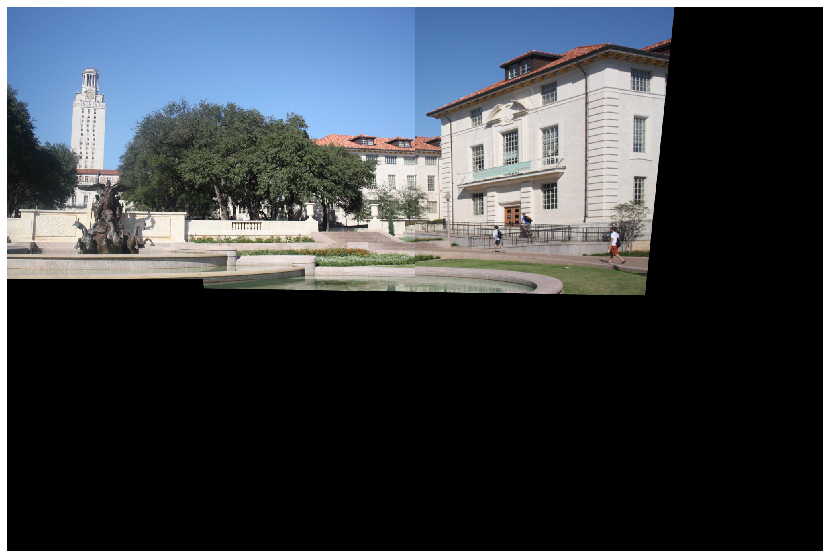

In [19]:
h = get_homography(kps_query, kps_train, matches, 4)

width = img_query.shape[1] + img_train.shape[1]
height = img_query.shape[0] + img_train.shape[0]

# przekształć dołączany obraz
result = cv2.warpPerspective(img_train, h, (width, height))

# dołącz obraz bazowy
result[:img_query.shape[0], :img_query.shape[1]] = img_query

plt.figure(figsize=(20, 10))
imshow(result)
plt.axis('off')
plt.show()

## Przycinanie panoramy

Aby przyciąć panoramę dokonamy następujących kroków:
- konwersja do skali szarości i progowanie dla progu 0
- wyszukiwanie konturów
- znalezienie maksymalnych wartości konturów
- dopasowanie kwadratu okalającego kontury
- slicing

(0, 0, 1676, 725)


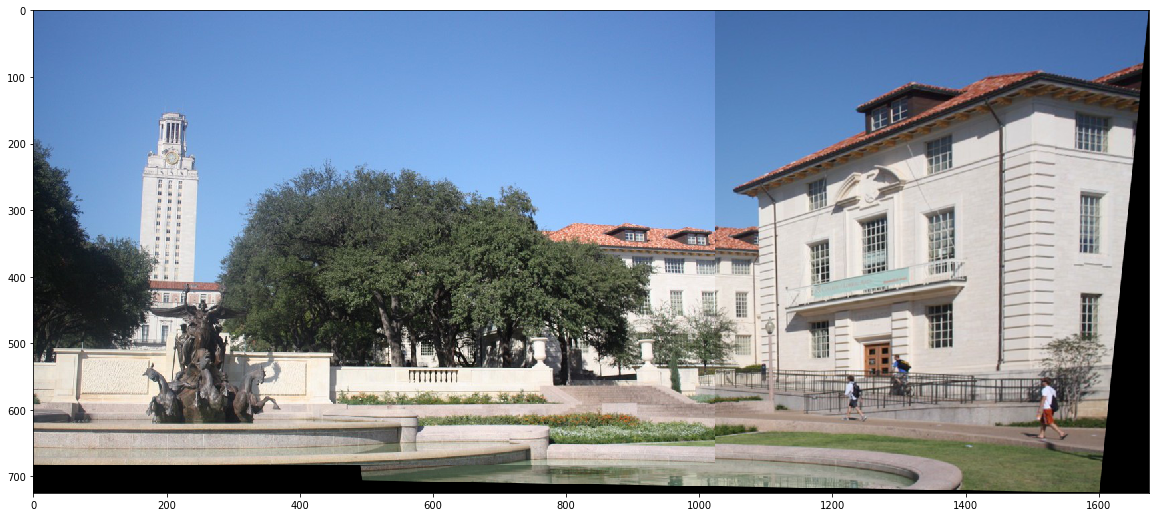

In [25]:
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
_ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
# if the length the contours tuple returned by cv2.findContours
# is '2' then we are using either OpenCV v2.4, v4-beta, or
# v4-official
if len(cnts) == 2:
    cnts = cnts[0]

# if the length of the contours tuple is '3' then we are using
# either OpenCV v3, v4-pre, or v4-alpha
elif len(cnts) == 3:
    cnts = cnts[1]

# maksymalny obszar

c = max(cnts, key=cv2.contourArea)

x, y, w, h = cv2.boundingRect(c)

plt.figure(figsize=(20, 10))
imshow(result[y:y+h, x:x+w])